# Seminar 4. Locomotion control
## Plan
* Create a CPG consisting of 4 neurons
* Make them produce the alternating oscillations

## Homework
* Tune CPG parameters to obtain the desired frequency and phase lags

## Materials
Russell, A., Orchard, G., & Etienne-Cummings, R. (2007, May). Configuring of spiking central pattern generator networks for bipedal walking using genetic algorthms. In 2007 IEEE International Symposium on Circuits and Systems (pp. 1525-1528). IEEE.



## 1. Create CPG of Adaptive LIF neurons

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np
import random

def plot_v_spikes(v_mon, s_mon, t_bounds=None, names=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    for i in range(len(v_mon.v)):
        if names:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=names[i])
        else:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=f'N_{i}')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

N = 4
V_REST = 1.5
TAU_V = 15 * b2.ms
V_RESET = 0
VT_0 = 1
TAU_T = 40 * b2.ms
THETA = 0.7
W_SYN = -1.5

def alif_group(num_neurons, v_rest=V_REST,tau_v=TAU_V, 
               v_reset=V_RESET, vt_0=VT_0, 
               tau_t=TAU_T, theta=THETA):
    eqs = '''
        dv/dt = (v_rest-v)/tau_v: 1
        dvt/dt = (vt_0-vt)/tau_t : 1
        tau_v : second
        v_rest : 1
        v_reset : 1
        vt_0 : 1
        tau_t : second
        theta : 1
        '''
    reset = '''
        v = v_reset
        vt += theta
        '''
    G = b2.NeuronGroup(num_neurons, model=eqs, reset=reset, threshold='v>vt',
                 method='linear')
    G.tau_v = tau_v
    G.v_rest = v_rest
    G.v_reset = v_reset
    G.vt_0 = 'rand()'
    G.tau_t = tau_t
    G.theta = theta
    G.vt = v_rest
    return G

class CPG:
    
    def __init__(self):
        self.N = 4
        self.neurons = alif_group(self.N)
        self.spike_mon = b2.SpikeMonitor(self.neurons)
        self.v_mon = b2.StateMonitor(self.neurons, ["v", "vt"], record=True)
        self.create_synapses()
        self.net = b2.Network(self.neurons, self.synapses, self.spike_mon, self.v_mon)
            
    def create_synapses(self):
        self.synapses = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        self.synapses.connect(i=0, j=1)
        self.synapses.connect(i=1, j=0)
        self.synapses.connect(i=1, j=2)
        self.synapses.connect(i=2, j=1)
        self.synapses.connect(i=2, j=3)
        self.synapses.connect(i=3, j=2)
        
    def get_periods(self):
        times = np.array(self.spike_mon.t)
        nums = np.array(self.spike_mon.i)
        
        t_mas = {}
        
        for num in np.sort(np.unique(nums)):
            neuron_times = times[nums == num]
            delta = np.mean([neuron_times[i + 1] - neuron_times[i] for i in range(len(neuron_times) - 1)]) * b2.ms
            t_mas[num] = []
            
            t_on, t_off = None, None
            for cur in neuron_times:
                if t_on is None:
                    t_on = cur
                    prev = cur
                    continue
                if (cur - prev) * b2.ms > delta:
                    t_off = prev
                    t_mas[num].append((t_on, t_off))
                    t_on, t_off = cur, None
                prev = cur
            if t_on and t_off is None:
                t_off = prev
                t_mas[num].append((t_on, t_off))
                t_on, t_off = cur, None
            
        return t_mas
    
    def plot_spikes(self, t_bounds=None, names=None, with_periods=True):
        v_mon, s_mon = self.v_mon, self.spike_mon
        if with_periods:
            periods = self.get_periods()
            
        b2.figure(figsize=(12,4))
        b2.subplot(121)
        for i in range(len(v_mon.v)):
            if names:
                b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=names[i])
            else:
                b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=f'N_{i}')
        if t_bounds:
            b2.xlim(t_bounds)
        b2.xlabel('Time (ms)')
        b2.ylabel('v')
        b2.legend();
        b2.subplot(122)
        b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
        if with_periods:
            for num in periods:
                for t_on, t_off in periods[num]:
                    b2.plot([t_on / b2.ms, t_off / b2.ms], [num, num])
        if t_bounds:
            b2.xlim(t_bounds)
        b2.xlabel('Time (ms)')
        b2.ylabel('Neuron num')

In [3]:
b2.start_scope()
cpg = CPG()
#PG = b2.PoissonGroup(1, 10*1/TAU_V)
cpg.net.run(500 * b2.ms, namespace={'w_syn':W_SYN})

WARNING    "vt_0" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [ ]:
# plot_v_spikes(cpg.v_mon, cpg.spike_mon, [0,500])
# plot_v_spikes(cpg.v_mon, cpg.spike_mon, [400,500])
# plt.plot(cpg.v_mon.t/b2.ms, cpg.v_mon.v[0], label='v')
# plt.plot(cpg.v_mon.t/b2.ms, cpg.v_mon.vt[0], label='vt')
# plt.legend()

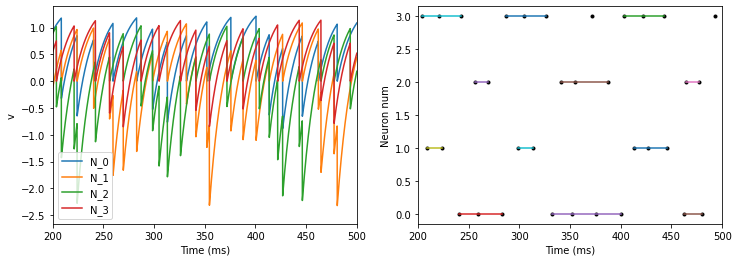

In [ ]:
cpg.plot_spikes([200, 500])

In [ ]:
period_opt = 100 * b2.ms
delta_ac = 0
delta_bd = 0
# bd after ac